## Add parameter

In [27]:
sentence = ':Anderson is $founder and :chairman of :Interface Inc.'
anchor = [3]
capture = [1, 5, 7]

In [25]:
import subprocess
import sys

subprocess.Popen('ls', cwd='C:/Users/guiro/Desktop/Research_S22/odinson', stdout=subprocess.PIPE, shell=True).stdout.read()


b''

In [20]:
subprocess.Popen("ls", shell=True, stdout=subprocess.PIPE).stdout.read()

b''

## Parse sentence and build graph

### Now performed via scala

In [392]:
# from nltk.parse.stanford import StanfordDependencyParser
# import os
# java_path = "C:/Program Files/Java/jdk1.8.0_231/bin/java.exe"
# os.environ['JAVAHOME'] = java_path

# # Path to CoreNLP jar unzipped
# jar_path = './stanford-corenlp-4.2.2/stanford-corenlp-4.2.2.jar'

# # Path to CoreNLP model jar
# models_jar_path = './stanford-corenlp-4.2.2-models-english.jar'


# # Initialize StanfordDependency Parser from the path
# parser = StanfordDependencyParser(path_to_jar = jar_path, path_to_models_jar = models_jar_path)

# # Parse the sentence
# result = parser.raw_parse(sentence)
# dependency = result.__next__()

# print ("{:<15} | {:<10} | {:<10} | {:<15} | {:<10}".format('Head', 'Head POS','Relation','Dependent', 'Dependent POS'))
# print ("-" * 75)
  
# # Use dependency.triples() to extract the dependency triples in the form
# # ((head word, head POS), relation, (dependent word, dependent POS))  
# for dep in list(dependency.triples()):
#   print ("{:<15} | {:<10} | {:<10} | {:<15} | {:<10}"
#          .format(str(dep[0][0]),str(dep[0][1]), str(dep[1]), str(dep[2][0]),str(dep[2][1])))





In [36]:
# from collections import defaultdict
# # build a graph from nodes
# graph = defaultdict(set)
# edges = {}
# nodes = []
# tokens = {}
# # make a undirected graph
# for node in dependency.nodes:
#     nodes.append(node)
#     nodecontent = dependency.nodes[node]
#     tokens[node] = nodecontent['word']
#     for rel in nodecontent['deps']:
#         nexts = nodecontent['deps'][rel]
#         for nextnode in nexts:
#             graph[node].add(nextnode)
#             graph[nextnode].add(node)

#             # outgoing edge
#             edges[(node, nextnode)] = '>' + rel

#             # incoming edge
#             edges[(nextnode, node)] = '<' + rel

from collections import defaultdict
# build a graph from nodes
graph = defaultdict(set)
edges = {}
nodes = []
tokens = {}
raw_tokens = sentence.split()
for i, toke in enumerate(raw_tokens):
    tokens[i + 1] = toke
with open('./extra/test.txt') as relations:
    # make a undirected graph
    for line in relations:
        node, modifier, rel = line.split()

        # # make a undirected graph
        # change to 1-based indexing
        node = int(node)
        modifier = int(modifier)
        # if rel[-2:] == '_\'':
        #     pass
        nodes.append(node)
        graph[node].add(modifier)
        graph[modifier].add(node)

        # outgoing edge
        edges[(node, modifier)] = '>' + rel

        # incoming edge
        edges[(modifier, node)] = '<' + rel
        
print(graph, edges, nodes)

defaultdict(<class 'set'>, {3: {1, 2, 4, 5, 8, 9}, 1: {3}, 2: {3}, 4: {3}, 5: {3}, 8: {3, 6, 7}, 9: {3}, 6: {8}, 7: {8}}) {(3, 1): '>nsubj', (1, 3): '<nsubj', (3, 2): '>cop', (2, 3): '<cop', (3, 4): '>cc', (4, 3): '<cc', (3, 5): '>conj_and', (5, 3): '<conj_and', (3, 8): '>nmod_of', (8, 3): '<nmod_of', (3, 9): '>dep', (9, 3): '<dep', (8, 6): '>case', (6, 8): '<case', (8, 7): '>compound', (7, 8): '<compound'} [3, 3, 3, 3, 3, 3, 8, 8]


## Reduce the dependency graph

In [29]:
# bfs algorithm to find the path between hooks and captures
# this assumes the path is unique
from collections import deque
query_edges = {}
query_graph = defaultdict(set)
def bfs(start, end):
    '''
    BFS function to find the path between start and end, and keeo the edges within the path
    '''
    if start == end:
        return
    path = []
    parent = {}
    visited = set([start])
    q = deque([start])
    while q:
        cur = q.popleft()
        if cur == end:
            # add edges to keep
            while cur != start:
                query_edges[(cur, parent[cur])] = edges[(cur, parent[cur])]
                query_edges[(parent[cur], cur)] = edges[(parent[cur], cur)]
                cur = parent[cur]
            # exit the loop
            break
        for nextnode in graph[cur]:
            if not nextnode in visited:
                parent[nextnode] = cur
                q.append(nextnode)
                visited.add(nextnode)

# # retrieve the query graph
for node1 in anchor+capture:
    for node2 in anchor+capture:
        bfs(node1, node2)

# build the query graph from the edges'
for i, j in query_edges:
    query_graph[i].add(j)
    query_graph[j].add(i)

## Visualize query graph

In [30]:
import networkx as nx
G = nx.DiGraph()
G.add_nodes_from(query_graph.keys())
edge_labels = {}
for edge in query_edges:
    if query_edges[edge][0] == '>':
        G.add_edge(*edge)
        edge_labels[edge] = query_edges[edge][1:]

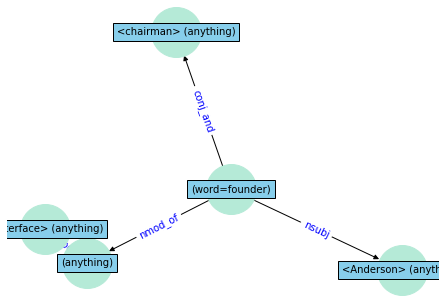

In [31]:
import matplotlib.pyplot as plt
node_labels = {}
for i in G.nodes:
    if i in anchor:
        node_labels[i] = '(word=' + tokens[i] + ')'
    elif i in capture:
        node_labels[i] = '<' + tokens[i] + '> (anything)'
    else:
        node_labels[i] = '(anything)' 
pos = nx.spring_layout(G)
plt.figure()

nx.draw(G, pos,with_labels=True, labels = node_labels, node_size=2500, bbox = dict(facecolor = "skyblue"), node_color='#B5EAD7', font_size=10)
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels=edge_labels,
    font_color='blue'
)
plt.axis('off')
plt.show()

In [32]:
print(query_graph)

defaultdict(<class 'set'>, {1: {3}, 3: {8, 1, 5}, 5: {3}, 7: {8}, 8: {3, 7}})


# Generate and parse query

In [41]:
# import copy
# # Reduce the graph to multiple lonest paths
# nodes = query_graph.keys()

# def get_path(cur, parent):
#     res = [cur]
#     while cur in parent:
#         cur = parent[cur]
#         res.append(cur)
#     res.reverse()
#     return res


# longest_paths = []
# remaining_edge = copy.deepcopy(query_edges)
# remaining_graph = copy.deepcopy(query_graph)
# while remaining_edge:
#     longest_path = []
#     for node in nodes:
#         parent = {}
#         stack = [(node, 1)]
#         visited = set([node])
        
#         while stack:
#             cur, length = stack.pop()
#             if length > len(longest_path):
#                 longest_path = get_path(cur, parent)
#             for nextnode in remaining_graph[cur]:
#                 if not nextnode in visited:
#                     visited.add(nextnode)
#                     stack.append((nextnode, length + 1))
#                     parent[nextnode] = cur
#     longest_paths.append(longest_path)
#     cur_edges = set([(longest_path[i], longest_path[i+1]) for i in range(len(longest_path) - 1)] + [(longest_path[i+1], longest_path[i]) for i in range(len(longest_path) - 1)])
#     for item in cur_edges:
#         del remaining_edge[item]
#         remaining_graph[item[0]].remove(item[1])
#     # visualize
# print(longest_paths)
# for longest_path in longest_paths:
#     query_string_builder = []
#     for i in range(len(longest_path) - 1):
#         cur = longest_path[i]
#         nex = longest_path[i + 1]
#         if cur in capture:
#             query_string_builder.append('(?<node' + str(cur) + '>[])')
#         elif cur in anchor:
#             query_string_builder.append(tokens[cur])
#         else:
#             query_string_builder.append('(?<node' + str(cur) + '>[])')
#         query_string_builder.append(edges[(cur, nex)])

#     last = longest_path[-1]
#     if last in capture:
#         query_string_builder.append('(?<node' + str(last) + '>[])')
#     elif last in anchor:
#         query_string_builder.append(tokens[cur])
#     else:
#         query_string_builder.append('(?<node' + str(last) + '>[])')
#     print(" ".join(query_string_builder))

[[1, 3, 8, 7], [3, 5]]
(?<node1>[]) <nsubj founder >nmod_of (?<node8>[]) >compound (?<node7>[])
founder >conj_and (?<node5>[])


In [35]:
nodes = query_graph.keys()

def get_path(cur, parent):
    res = [cur]
    while cur in parent:
        cur = parent[cur]
        res.append(cur)
    res.reverse()
    return res


longest_path = []
for node in nodes:
    parent = {}
    stack = [(node, 1)]
    visited = set([node])
    
    while stack:
        cur, length = stack.pop()
        if length > len(longest_path):
            longest_path = get_path(cur, parent)
        for nextnode in query_graph[cur]:
            if not nextnode in visited:
                visited.add(nextnode)
                stack.append((nextnode, length + 1))
                parent[nextnode] = cur
print(longest_path)

query_string_builder = []
for i in range(len(longest_path) - 1):
    cur = longest_path[i]
    nex = longest_path[i + 1]
    if cur in capture:
        query_string_builder.append('(?<node' + str(cur) + '>[])')
    elif cur in anchor:
        query_string_builder.append(tokens[cur])
    else:
        query_string_builder.append('(?<node' + str(cur) + '>[])')
    query_string_builder.append(edges[(cur, nex)])

last = longest_path[-1]
if last in capture:
    query_string_builder.append('(?<node' + str(last) + '>[])')
elif last in anchor:
    query_string_builder.append(tokens[cur])
else:
    query_string_builder.append('(?<node' + str(last) + '>[])')
print(" ".join(query_string_builder))

with open('./extra/src/main/resources/example/generated_rules.yml', 'w+') as f:
    f.write('rules:\n')
    f.write('  - name: rule1\n')
    f.write('    label: Person\n')
    f.write('    type: basic\n')
    f.write('    priority: 1\n')
    f.write('    pattern: |\n')
    f.write('      ' + ' '.join(query_string_builder))
    
print(' '.join(query_string_builder))

[1, 3, 8, 7]
(?<node1>[]) <nsubj founder >nmod_of (?<node8>[]) >compound (?<node7>[])
(?<node1>[]) <nsubj founder >nmod_of (?<node8>[]) >compound (?<node7>[])


## Generate query string (deprecated)

In [405]:
# ## Generate query string
# query_string_builder = []
# visited = set()
# q = deque([sorted(G.nodes)[0]])
# while q:
#     cur = q.popleft()
#     visited.add(cur)
#     if cur in capture:
#         query_string_builder.append('(?<' + tokens[cur] + '>[])')
#     elif cur in anchor:
#         query_string_builder.append(tokens[cur])
#     else:
#         query_string_builder.append('[]')
#     for j in query_graph[cur]:
#         if not j in visited:
#             q.append(j)
#             query_string_builder.append(query_edges[(cur, j)])

# with open('./extra/src/main/resources/example/generated_rules.yml', 'w+') as f:
#     f.write('rules:\n')
#     f.write('  - name: rule1\n')
#     f.write('    label: Person\n')
#     f.write('    type: basic\n')
#     f.write('    priority: 1\n')
#     f.write('    pattern: |\n')
#     f.write('      ' + ' '.join(query_string_builder))
    
# print(' '.join(query_string_builder))
    

(?<Anderson>[]) <nsubj founder >nmod_of [] >compound (?<Interface>[])


## Run extraction

## Filter extraction results

In [32]:
import stanza
nlp = stanza.Pipeline(lang='en', processors='tokenize,mwt,pos,lemma,depparse')

2022-11-29 16:55:24 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2022-11-29 16:55:24 WARNING: Can not find mwt: default from official model list. Ignoring it.


2022-11-29 16:55:39 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |
| lemma     | combined |
| depparse  | combined |

2022-11-29 16:55:39 INFO: Use device: gpu
2022-11-29 16:55:39 INFO: Loading: tokenize
2022-11-29 16:55:44 INFO: Loading: pos
2022-11-29 16:55:44 INFO: Loading: lemma
2022-11-29 16:55:44 INFO: Loading: depparse
2022-11-29 16:55:45 INFO: Done loading processors!


In [33]:
doc = nlp('Anderson is founder and chairman of Interface Inc.')


In [ ]:
import json, copy
def verify_result(json_str, longest_path):
    '''
    Determines if a sentence contains the whole query graph
    '''
    verified_edges = set([(longest_path[i], longest_path[i+1]) for i in range(len(longest_path) - 1)] + [(longest_path[i+1], longest_path[i]) for i in range(len(longest_path) - 1)])
    verified_nodes = set(longest_path)
    
    result = json.loads(json_str)
    matches = result["arguments"]
    mapping = {} # maps query graph node to actual node
    for node in matches:
        mapping[int(node[-1])] = matches[node]["odinsonMatch"]["start"] + 1
    
    # check the remainder of query graph
    doc = nlp(' '.join(result['detail']['document']['raw']))[0]
    doc_graph = {}
    for entry in doc:
        doc_graph[(entry.id, entry.head)] = "<" + entry.dprel
        doc_graph[(entry.head, entry.id)] = ">" + entry.dprel

    to_verify = copy.deepcopy(query_edges)
    
    for item in to_verify:
        if item in verified_edges:
            del item
    keep_run = True
    valid = True
    while keep_run:
        for edge in to_verify:
            if edge[0] or edge[1] in verified_nodes:
                # verify the edge


In [35]:
print(query_edges)

{(1, 3): '<nsubj', (3, 1): '>nsubj', (5, 3): '<conj_and', (3, 5): '>conj_and', (7, 8): '<compound', (8, 7): '>compound', (8, 3): '<nmod_of', (3, 8): '>nmod_of'}


In [34]:
print(*[f'id: {word.id}\tword: {word.text}\thead id: {word.head}\thead: {sent.words[word.head-1].text if word.head > 0 else "root"}\tdeprel: {word.deprel}' for sent in doc.sentences for word in sent.words], sep='\n')

id: 1	word: Anderson	head id: 3	head: founder	deprel: nsubj
id: 2	word: is	head id: 3	head: founder	deprel: cop
id: 3	word: founder	head id: 0	head: root	deprel: root
id: 4	word: and	head id: 5	head: chairman	deprel: cc
id: 5	word: chairman	head id: 3	head: founder	deprel: conj
id: 6	word: of	head id: 8	head: Inc	deprel: case
id: 7	word: Interface	head id: 8	head: Inc	deprel: compound
id: 8	word: Inc	head id: 3	head: founder	deprel: nmod
id: 9	word: .	head id: 3	head: founder	deprel: punct


In [38]:
edges

{(3, 1): '>nsubj',
 (1, 3): '<nsubj',
 (3, 2): '>cop',
 (2, 3): '<cop',
 (3, 4): '>cc',
 (4, 3): '<cc',
 (3, 5): '>conj_and',
 (5, 3): '<conj_and',
 (3, 8): '>nmod_of',
 (8, 3): '<nmod_of',
 (3, 9): '>dep',
 (9, 3): '<dep',
 (8, 6): '>case',
 (6, 8): '<case',
 (8, 7): '>compound',
 (7, 8): '<compound'}

In [406]:
import json
  
# Opening JSON file
with open('example_extractions_experiement.jsonl', 'r') as json_file:
    json_list = list(json_file)


documents = set()
for json_str in json_list:
    result = json.loads(json_str)
    document_raw = result['detail']['document']['raw']
    document = ' '.join(document_raw)
    
    if True:
        print('Result: ')
        print('docID: ', result['docId'])
        print('document: ', document)
        print('Captures: ')
        for item in result["odinsonMatch"]["namedCaptures"]:
            print('Capture name: ', item['name'])
            print("Capture idxs: ", item['capturedMatch']['start'], '-', item['capturedMatch']['end'])
            print("Capture words: ", document_raw[item['capturedMatch']['start']: item['capturedMatch']['end']])
        documents.add(document)
        print('\n')

Result: 
docID:  1
document:  Anderson is founder and chairman of Interface Inc.
Captures: 
Capture name:  Anderson
Capture idxs:  0 - 1
Capture words:  ['Anderson']
Capture name:  Interface
Capture idxs:  6 - 7
Capture words:  ['Interface']


Result: 
docID:  1
document:  Anderson who is the founder and director of the Word Education Foundation , currently engages in research and implementation of sustainable developmental projects , globally .
Captures: 
Capture name:  Anderson
Capture idxs:  1 - 2
Capture words:  ['who']
Capture name:  Interface
Capture idxs:  9 - 10
Capture words:  ['Word']


Result: 
docID:  1
document:  Anderson who is the founder and director of the Word Education Foundation , currently engages in research and implementation of sustainable developmental projects , globally .
Captures: 
Capture name:  Anderson
Capture idxs:  1 - 2
Capture words:  ['who']
Capture name:  Interface
Capture idxs:  10 - 11
Capture words:  ['Education']


